<a href="https://colab.research.google.com/github/Supathatkh/datasci_/blob/main/04v_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image classification

จากบทเรียนที่น้องๆได้ลองเรียนมานั้น จะเห็นว่า Deep learning สามารถนำไปใช้งานได้หลากหลายวิธีมากๆ หนึ่งในงานที่ใช้กันแพร่หลายมากคือ Image classification

โดยในบทเรียนแรกนี้เราจะมาลองทำ Image classification กันโดยใช้ library ตั้งแต่ FastAI, Pytorch และ Pytorch Ignite

โดย Dataset ที่เราจะเลือกใช้ในวันนี้จะใช้ชุดข้อมูลจาก Kaggle https://www.kaggle.com/c/dog-breed-identification

##Explore ชุดข้อมูล

*   Download ชุดข้อมูล (ไปที่ Account มุมขวาบน > ใน section API กด "Create New API 
*   Token" > นำไปวางในโฟลเดอร์ ~/.kaggle/kaggle.json)
เตรียมชุดข้อมูลให้เหมาะสมกับการเทรนโมเดล (โค้ดตามด้านล่าง)
Downloaded format:
train/
test/
labels.csv

Preferred format:
- root_dir/train/
    breed1/
    breed2/
    breed3/
- root_dir/validation/
    breed1/
    breed2/
    breed3/
- root_dir/test/
    breed1/
    breed2/
    breed3/

In [11]:
# ! นำหน้าใน Notebook แปลว่าให้รันใน Terminal
!pip install kaggle
from google.colab import files #อัพโหลดไฟล์ kaggle.json เพื่อเชื่อม kaggle เข้ากับ colab
files.upload()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahcee","key":"d99be866800020a6aaa79895f663ce0e"}'}

In [12]:
#เชื่อม kaggle เข้ากับ colab
! mkdir ~/.kaggle
! cp kaggle.json  ~/.kaggle/
! cp chmod 600 ~/.kaggle/kaggle.json


cp: target '/root/.kaggle/kaggle.json' is not a directory


In [13]:
!kaggle competitions download -c dog-breed-identification #โหลดไฟล์ทีจะใช้ในการ classification

 96% 665M/691M [00:25<00:01, 21.9MB/s]
100% 691M/691M [00:25<00:00, 28.7MB/s]


In [14]:
!unzip dog-breed-identification.zip -d data #แตกไฟล์ zip ที่โหลดมาจาก kaggle

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488bf4cbb.jpg 

In [15]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [16]:
# get all image paths
img_df = pd.DataFrame(glob("data/train/*.jpg"), columns=["path"])
img_df["id"] = img_df.path.map(lambda x: op.basename(x).replace(".jpg", ""))

# read label data
label_df = pd.read_csv("data/labels.csv")
train_df = img_df.merge(label_df, on="id")

In [17]:
from PIL import Image #Import ไลบรารี่ที่ใช้ดูรูปภาพ

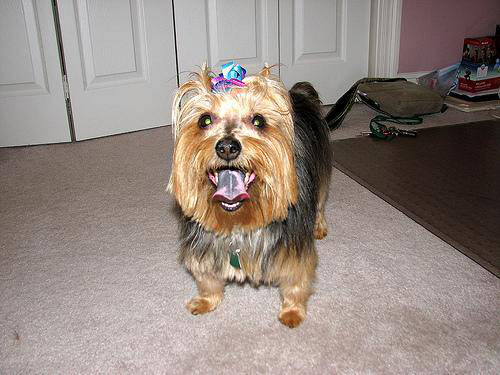

In [18]:
Image.open(glob("data/train/*.jpg")[20])

In [19]:
glob("data/train/*.jpg")[0:100]

['data/train/45274565acecb88e4e8fa29f85e7dda9.jpg',
 'data/train/e6898f5cc43bb4a30970f2d2210fdb9a.jpg',
 'data/train/8c3e7fd14b975242c61afc05228b0e50.jpg',
 'data/train/228e7403fbfab41c7586de3afb83887b.jpg',
 'data/train/ef029489fc2941792a5460afd7345fcc.jpg',
 'data/train/4fc628e8fbd164b2e35f616af5cc8f41.jpg',
 'data/train/8a1129e4fd587efdc8ef8c8cc08664e4.jpg',
 'data/train/fd2fbb4ff4bfe775d0267f4737c67521.jpg',
 'data/train/7968fee6de08f19f2a783e5b9a8bd46f.jpg',
 'data/train/52b721b1626b1658b5b34c080e925897.jpg',
 'data/train/6a0086f476eaa05112f1074e40dfb679.jpg',
 'data/train/1081c1b755f05b219275afd0989c6748.jpg',
 'data/train/b8bea4b3a40836ea881062273abd805f.jpg',
 'data/train/295cb1a9b5d64689cae62dd2964bc070.jpg',
 'data/train/6cc27c87f5f463567bb64c338436488a.jpg',
 'data/train/f9a1339b0ef12e47ae875a86cf91524b.jpg',
 'data/train/de51f05ddadfb52e97fbc8799891ea8c.jpg',
 'data/train/f95ac23ee909194006c538c4fc6e6750.jpg',
 'data/train/cf82709a00a4f2168555b8f77c0d815d.jpg',
 'data/train

In [20]:
print("Number of test images = ", len(glob("data/test/*.jpg")))

Number of test images =  10357


In [21]:
print("Number of train images = ", len(train_df))

Number of train images =  10222


In [22]:
train_df.head()

,path,id,breed
0,data/train/45274565acecb88e4e8fa29f85e7dda9.jpg,45274565acecb88e4e8fa29f85e7dda9,leonberg
1,data/train/e6898f5cc43bb4a30970f2d2210fdb9a.jpg,e6898f5cc43bb4a30970f2d2210fdb9a,dhole
2,data/train/8c3e7fd14b975242c61afc05228b0e50.jpg,8c3e7fd14b975242c61afc05228b0e50,gordon_setter
3,data/train/228e7403fbfab41c7586de3afb83887b.jpg,228e7403fbfab41c7586de3afb83887b,lhasa
4,data/train/ef029489fc2941792a5460afd7345fcc.jpg,ef029489fc2941792a5460afd7345fcc,bouvier_des_flandres


In [23]:
root_dir = "data/train_breed"
for _, r in train_df.iterrows():
    if not op.exists(f"{root_dir}/{r.breed}"):
        os.makedirs(f"{root_dir}/{r.breed}")
    shutil.copy(r.path, f"{root_dir}/{r.breed}/{r.id}.jpg")

##Image classification ด้วย FastAI

*   blocks ใช้สำหรับใส่คู่ระหว่าง input และ output ในที่นี้คือ ImageBlock, CategoryBlock
*   เราจะใช้ get_items ในการดึงภาพออกมาจากโฟลเดอร์ โดย get_image_files เป็นฟังก์ชันของ FastAI ที่ใช้หา path สำหรับโฟลเดอร์ที่กำหนด
*   โดยเราจะใช้ get_y ในการหาว่า label ของแต่ละภาพคืออะไร ในที่นี้คือใช้ฟังก์ชัน parent_label ของ FastAI เช่นกัน
*  รูปแบบของการวางโฟลเดอร์เป็นดังนี้ <grant_parent>/<parent>/<img.jpg>
*  item_tfms เป็นการ transform ภาพก่อนที่จะส่งไปยัง GPU ในที่นี่เราจะทำการย่อภาพก่อนที่จะส่งไปยัง GPU
*  batch_tfms เป็นการ transform ภาพใน GPU ในที่นี้เราจะใช้ aug_transforms ซึ่งเป็นฟังก์ชันของ FastAI ในการทำให้ภาพมีความหลากหลายมากยิ่งขึ้น





In [24]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [25]:
from fastbook import *

In [26]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [27]:
get_image_files("data/test/")

(#10357) [Path('data/test/9861af75e3cd895f7cdf6e9aca56778b.jpg'),Path('data/test/ecb6362d105c0cb84d8e69cfd9b8d0b5.jpg'),Path('data/test/6d15ae3e88e32472a777752502f5ef61.jpg'),Path('data/test/e67cd079a0f9c15ebee3c41743906c73.jpg'),Path('data/test/d89ed6450dc6f1a04caaafe186411358.jpg'),Path('data/test/12a8312dcf3d19999da1d4ce3c529015.jpg'),Path('data/test/49593c08eb1b55c629fa03a939f54626.jpg'),Path('data/test/a8b462c178d69221ee633d425785133c.jpg'),Path('data/test/f9c6eaf6f490f30fdecd76831805d0f7.jpg'),Path('data/test/91509dedbc2414e9a97cd9d831ddcc9c.jpg')...]

In [28]:

parent_label("data/test/000621fb3cbb32d8935728e48679680e.jpg")

'test'

In [29]:
dls = fields.dataloaders("data/train_breed/")

In [30]:

dls.vocab

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

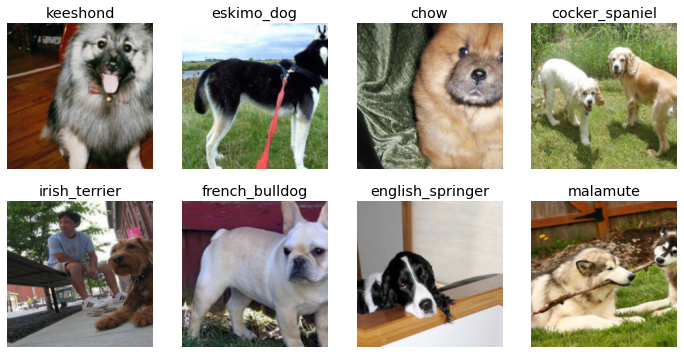

In [31]:
dls.train.show_batch(max_n=8, nrows=2)

In [35]:
learner = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [37]:
#learner.lr_find() # หา learning rate ที่เหมาะสม

In [38]:
learner.fine_tune(epochs=2, freeze_epochs=1, base_lr=0.0012)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.630165,1.450784,0.400685,0.599315,27:12


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.753209,0.964130,0.292074,0.707926,38:43
1,1.372459,0.883327,0.267613,0.732387,38:50


##ทำนายผล

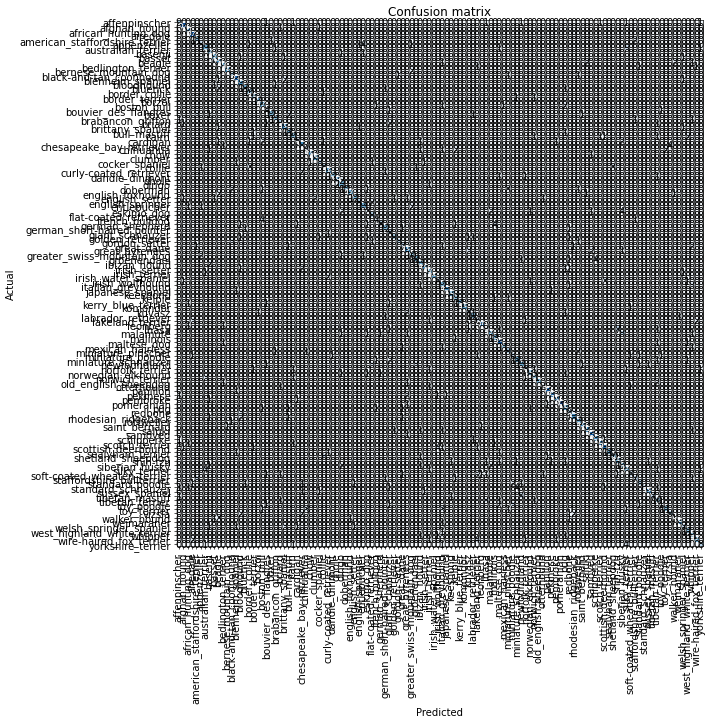

In [42]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [43]:
interp.most_confused(min_val=5)

[('malamute', 'siberian_husky', 8),
 ('lhasa', 'shih-tzu', 7),
 ('shetland_sheepdog', 'collie', 6),
 ('australian_terrier', 'silky_terrier', 5),
 ('beagle', 'basset', 5),
 ('staffordshire_bullterrier', 'american_staffordshire_terrier', 5),
 ('tibetan_mastiff', 'newfoundland', 5),
 ('toy_poodle', 'miniature_poodle', 5)]

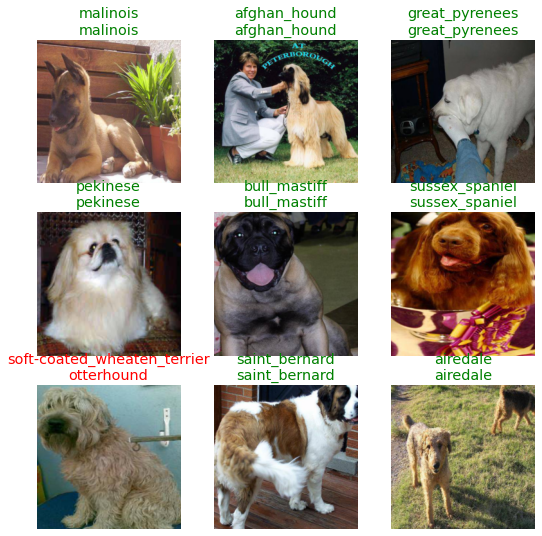

In [44]:
learner.show_results(shuffle=True)

##เซฟโมเดล

In [45]:
learner.export("dbc_resnet34_fastai.pkl")

##โหลดโมเดลเพื่อทำนายผล

In [46]:
from fastbook import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

learn_inf = load_learner('dbc_resnet34_fastai.pkl')

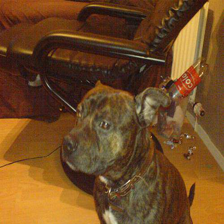

In [47]:
Image.open("data/test/0953e8a5ff606ad468a9113317627652.jpg").resize((224, 224))

In [48]:
learn_inf.predict("data/test/0953e8a5ff606ad468a9113317627652.jpg")

('boxer',
 TensorBase(21),
 TensorBase([8.1029e-04, 3.2317e-04, 4.8010e-03, 4.7390e-03, 6.4977e-02, 2.5281e-04, 1.0615e-04, 6.2969e-03, 5.7908e-04, 8.4685e-04, 1.8530e-03, 8.4994e-05, 4.1318e-03, 1.7360e-04, 1.7083e-02, 1.7334e-03,
         7.5819e-05, 8.2868e-03, 3.8704e-04, 1.8011e-03, 2.7935e-03, 1.8681e-01, 5.9371e-03, 2.9449e-03, 4.8478e-04, 3.2583e-02, 4.3932e-03, 2.3381e-03, 4.5073e-02, 2.4173e-04, 1.9105e-03, 4.0619e-04,
         1.1163e-03, 9.9181e-05, 9.0509e-03, 1.0265e-04, 3.3822e-03, 4.9009e-03, 6.1501e-03, 7.1633e-04, 2.0981e-04, 8.9229e-04, 1.6191e-04, 6.7708e-04, 3.7103e-03, 1.5137e-02, 2.4259e-03, 1.0314e-02,
         2.8780e-02, 7.3906e-04, 7.7578e-05, 2.6382e-02, 5.1008e-04, 1.2559e-03, 1.2061e-03, 1.3531e-03, 6.3584e-04, 1.6847e-02, 2.1977e-03, 9.3799e-04, 5.5627e-03, 2.0847e-04, 1.7618e-03, 1.6281e-03,
         1.6500e-03, 8.5773e-04, 1.7199e-04, 6.9123e-03, 3.0060e-03, 3.3948e-03, 7.4387e-04, 9.0022e-04, 1.7970e-01, 2.4542e-05, 1.0052e-02, 6.3676e-03, 9.1535e-05, 